In [3]:
import pandas as pd
import numpy as np
import sqlalchemy
from urllib.parse import urlencode
import requests
from requests import Response
import datetime as dt
from datetime import time, date, timedelta
from dateutil.relativedelta import relativedelta
import itertools
from math import ceil
import scipy.stats as stats
import matplotlib.pyplot as plt

In [16]:
from ta.trend import MACD
def MACD_Run(fast_length,slow_length, signal_length,ploting):
    result = pd.read_csv('raw-weekly-pricevolume.csv')
    codes = result['code'].unique().tolist()
    for code in codes:
        close_weekly = result[result['code']==code]['close_weekly']
        result.loc[(result['code'] == code)&(result['code'].shift(slow_length)),'macd'] = MACD(close=close_weekly,window_fast=fast_length,window_slow=slow_length,window_sign=signal_length).macd()/result['close_weekly']
    result = result.dropna()
    
    result.loc[result['code'] == result['code'].shift(1),'return'] = result['close_weekly']/result['close_weekly'].shift(1) - 1
    result.loc[(result['code'] == result['code'].shift(1))&(result['macd']>0.015),'signal'] = 1
    result.loc[(result['code'] == result['code'].shift(1))&(result['macd']<-0.015),'signal'] = 0
    result.loc[result['code'] != result['code'].shift(1),'signal'] = 0
    result = result.ffill()
    result.loc[result['code'] == result['code'].shift(1),'daily_return'] = result['signal'].shift(1)*result['return']
    result.loc[(result['code'] == result['code'].shift(1))&(result['signal']==1)&(result['signal'].shift(1)==0),'daily_return']=result['daily_return']-0.005
    dailyprofit = pd.pivot(result, index = 'date', columns = 'code', values = 'daily_return')
    dailyprofit = dailyprofit.replace(0, np.nan)
    dailyprofit.reset_index(inplace = True)
    day_return = dailyprofit.copy()
    day_return['count'] = day_return.iloc[:,1:len(dailyprofit.columns.to_list())].count(axis = 1) #exclude date column
    day_return.loc[day_return['count']<5,'profit'] = day_return.iloc[:,1:len(dailyprofit.columns.to_list())].mean(axis = 1,skipna=True)*(day_return['count']/5)
    day_return.loc[day_return['count']==0,'profit'] = 0
    day_return.loc[day_return['count']>=5,'profit'] = day_return.iloc[:,1:len(dailyprofit.columns.to_list())].mean(axis = 1,skipna=True)

    profit = (day_return['profit'] +1).cumprod()

    day_return['cumulative'] = profit
    if ploting == 1: 
        plt.plot(profit)
    cul_arr = day_return['cumulative'].to_list()
    dd_arr = []
    maxcul = 0
    for x in day_return.cumulative.dropna().tolist():
        if x >= maxcul:
            maxcul = x
            dd_arr.append(0)
        else:
            dd_arr.append((maxcul-x)/maxcul)
    print(f'MDD {max(dd_arr)}')
    return float(profit[-1:]), fast_length,slow_length

    

MDD 0.21191711930017657


(3.6980330607297676, 4, 2)

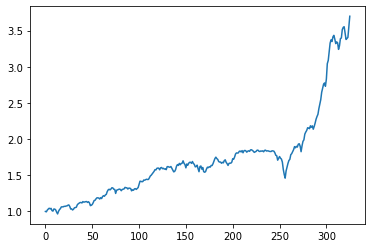

In [14]:
MACD_Run(4,2,9,1)